In [20]:
import json, os, itertools, re
from collections import defaultdict
import gurobipy as gp
import pandas as pd
import numpy as np

In [21]:
BASE_DIR = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json"
edge_fp   = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json\5 min\edges.json"
route_fp  = os.path.join(BASE_DIR, "routes_nodes.json")
demand_fp = os.path.join(BASE_DIR, "demand_full.json")
dept_fp   = os.path.join(BASE_DIR, "dep_time.json")


T = 96
max_wait = 4

# CAPACITY = 3
CAPACITY_EDGE = 3
CAPACITY_NODE = 2

failed_edges = {"e70","e70r","e62","e62r","e59","e59r","e63","e63r","e71","e71r","e80","e80r","e83","e83r","e87","e87r","e75","e75r","e82","e82r","e86","e86r","e90","e90r","e92","e92r","e94","e94r","e14","e14r","e13","e13r","e15","e15r","e18","e18r","e24","e24r","e35","e35r","e34","e34r","e27","e27r","e23","e23r","e21","e21r","e2","e2r","e6","e6r","e10","e10r","e12","e12r","e16","e16r"}
w1, w2, w3, w4, w5 = 1000, 1000, 100, 500, 100
BIG_M = 10**6
SINK  = "SINK"
DWELL_MIN   = 1

FAIL_T   = 48
T_clear  = 96


with open(edge_fp, encoding="utf-8") as f:
    edges_raw = json.load(f)
edges = {eid: (src, dst, int(tau)) for eid, (src, dst, tau) in edges_raw.items()}

with open(route_fp, encoding="utf-8") as f:
    routes_nodes = json.load(f)

with open(dept_fp, encoding="utf-8") as f:
    dep_time = {tr: int(t) for tr, t in json.load(f).items()}

with open(demand_fp, encoding="utf-8") as f:
    dem_raw = json.load(f)
demand = {tr: [(o, d, float(q)) for o, d, q in lst] for tr, lst in dem_raw.items()}

trains = list(routes_nodes)
nodes  = {n for _, (s, d, _) in edges.items() for n in (s, d)}
nodes.add(SINK)


In [22]:
def route_prefix(tr_id: str) -> str: # e.g. "A1234_1" -> "A"
    m = re.match(r'^([^\d]+)\d+_\d+$', tr_id)
    return m.group(1) if m else tr_id.rsplit('_', 1)[0]


def travel_time_only(path, edges): 
    total = 0
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        total += edges[eid][2]
    return total


def build_sched(routes_nodes, edges, dep_time, DWELL_MIN):
    """
    sched = {
  "A1234_1": {
    "A": {"arr": 10, "dep": 10},
    "B": {"arr": 12, "dep": 13},  # A→B(2 min) 
    "C": {"arr": 16, "dep": 16}   # B→C(3 min)
  },
    """
    sched = {}
    for tr, path in routes_nodes.items():
        t = dep_time[tr]
        arr = {path[0]: {"arr": t, "dep": t}}
        for i, (u, v) in enumerate(zip(path[:-1], path[1:])):
            eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
            travel = edges[eid][2]
            t += travel
            arr[v] = {"arr": t, "dep": t}
            if i < len(path) - 2:
                arr[v]["dep"] += DWELL_MIN
                t += DWELL_MIN
        sched[tr] = arr
    return sched

sched = build_sched(routes_nodes, edges, dep_time, DWELL_MIN)


from collections import defaultdict as DD
by_route = DD(list)
"""
by_route = {
  "A1234": ["A1234_1", "A1234_2"],
}
"""
for tr in trains:
    by_route[route_prefix(tr)].append(tr)


route_runtime = {}
"""
# without dwell time
route_runtime = {
  "A1234": 2 + 3,   # A→B(2) + B→C(3) = 5
}
"""
for rname, tr_list in by_route.items():
    reps = [tr for tr in tr_list if re.fullmatch(re.escape(rname) + r'\d+_1', tr)]
    if not reps:
        reps = [tr for tr in tr_list if tr.endswith('_1')]
    if not reps:
        reps = [sorted(tr_list)[0]]
    rep = reps[0]
    base_run = travel_time_only(routes_nodes[rep], edges)
    route_runtime[rname] = base_run


PADDING_BASE = 6
T_limit = {}
for tr in trains:
    L = len(routes_nodes[tr]) - 1
    dwell_need = max(0, L-1) * DWELL_MIN
    base_run = route_runtime[route_prefix(tr)]
    T_limit[tr] = min(T, dep_time[tr] + base_run + dwell_need + PADDING_BASE)


q_r = {tr: sum(q for *_, q in demand[tr]) for tr in trains}


uv2eid = {} # (u,v) -> eid
dup_keys = set()
for eid, (s, d, _) in edges.items():
    key = (s, d)
    if key in uv2eid and uv2eid[key] != eid:
        dup_keys.add(key)
    else:
        uv2eid[key] = eid
if dup_keys:
    print(f"[warn] multiple eids share the same (u,v): {sorted(list(dup_keys))[:5]} ...")


def planned_eids_of(tr):
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = uv2eid.get((u, v))
        if eid is None:
            raise KeyError(f"No edge (u={u} -> v={v}) in edges; check routes_nodes or edges.json")
        eids.append(eid)
    return eids

planned_eids = {tr: planned_eids_of(tr) for tr in trains}
blocked = {tr: int(any(e in failed_edges for e in planned_eids[tr])) for tr in trains}
T_aff = [tr for tr in trains if blocked[tr] == 1]
T_ok  = [tr for tr in trains if blocked[tr] == 0]


def get_arrival(tr, node, default=10**9):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("arr" in e):
        return e["arr"]
    return default

allow_stop = {}
reach = {}

for tr in trains:
    path = routes_nodes[tr]
    eids = planned_eids[tr]
    L = len(path) - 1  # 엣지 개수, 노드 인덱스는 0..L

    # 도달 가능성
    last_node = path[-1]
    t_arrival_last = get_arrival(tr, last_node, default=10**9)
    reach[tr] = int(t_arrival_last <= T_limit[tr])

    # 첫 고장 엣지 인덱스 j (없으면 None)
    first_fail = next((idx for idx, e in enumerate(eids) if e in failed_edges), None)

    for i in range(1, L + 1):  # 노드 인덱스 1..L (중간~종착)
        n = path[i]

        if i == L:
            allow = 1  # 종착은 항상 허용
        elif reach[tr] == 0:
            allow = 1  # 도달 불가면 어디서든 종료 허용(정책 유지)
        else:
            # 고장 이후 노드에서만 허용: i >= first_fail+1
            if first_fail is not None and i >= (first_fail + 1):
                allow = 1
            else:
                allow = 0

        allow_stop[(tr, n)] = int(allow)


In [23]:
CROSS = {}
"""
CROSS[tr] = (u, v, eid, t0, t1)

# CROSS stores arcs where FAIL_T lies inside (t0, t1]:
- 45–55 arc → stored (train is on arc during FAIL_T)
- 30–50 arc → stored (train arrives exactly at FAIL_T)

e.g.
CROSS = {
  "A1234_1": ("S", "M", "e10", 30, 50),  
}
"""
for tr in trains:
    path = routes_nodes[tr]
    t = dep_time[tr]
    for u, v in zip(path[:-1], path[1:]):
        eid = uv2eid[(u, v)]
        tau = edges[eid][2]
        t0, t1 = t, t + tau
        if t0 < FAIL_T <= t1:
            CROSS[tr] = (u, v, eid, t0, t1)
            break
        t = t1
        if v != path[-1]:
            t += DWELL_MIN

In [24]:
def sched_arr(tr, node, default=None):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("arr" in e):
        return e["arr"]
    return default


def initial_snapshot_at_FAIL_T():
    start_node, start_time = {}, {}
    """
    - If FAIL_T crosses an arc for train tr:
    start_node[tr] = arrival node of that arc
    start_time[tr] = arrival time t1

    - Else:
    pick the latest node with planned arr <= FAIL_T
    start_node[tr] = node
    start_time[tr] = max(FAIL_T, that arrival time)  # effectively FAIL_T

    - If nothing arrived yet (depart x):
    start_node[tr] = origin node (path[0])
    start_time[tr] = max(FAIL_T, dep_time[tr])
    """

    for tr in trains:
        if tr in CROSS:
            _, v, _, _, t1 = CROSS[tr]
            start_node[tr] = v
            start_time[tr] = t1
        else:
            path = routes_nodes[tr]
            cand = []
            for n in path:
                ta = sched_arr(tr, n)
                if ta is not None and ta <= FAIL_T:
                    cand.append((ta, n))
            if cand:
                ta, n = max(cand)
                start_node[tr] = n
                start_time[tr] = max(FAIL_T, ta)
            else:
                start_node[tr] = path[0]
                start_time[tr] = max(FAIL_T, dep_time[tr])
    return start_node, start_time

start_node, start_time = initial_snapshot_at_FAIL_T()

print("start_node:", start_node)
print("start_time:", start_time)


start_node: {'경부고속철도1_1': 'n79', '경부고속철도1_2': 'n79', '경부고속철도1_3': 'n75', '경부고속철도1_4': 'n72', '경부고속철도1_5': 'n72', '경부고속철도1_6': 'n60', '경부고속철도1_7': 'n60', '경부고속철도1_8': 'n42', '경부고속철도1_9': 'n42', '경부고속철도1_10': 'n28', '경부고속철도1_11': 'n18', '경부고속철도1_12': 'n18', '경부고속철도2_1': 'n3', '경부고속철도2_2': 'n1', '경부고속철도2_3': 'n2', '경부고속철도2_4': 'n2', '경부고속철도2_5': 'n13', '경부고속철도2_6': 'n13', '경부고속철도2_7': 'n18', '경부고속철도2_8': 'n28', '경부고속철도2_9': 'n28', '경부고속철도2_10': 'n42', '경부고속철도2_11': 'n42', '경부선1_1': 'n73', '경부선1_2': 'n63', '경부선1_3': 'n59', '경부선1_4': 'n41', '경부선1_5': 'n41', '경부선1_6': 'n28', '경부선2_1': 'n9', '경부선2_2': 'n14', '경부선2_3': 'n28', '경부선2_4': 'n28', '경부선2_5': 'n46', '경부선2_6': 'n60', '경북선1_1': 'n41', '경북선2_1': 'n43', '경전선1_1': 'n73', '경전선1_2': 'n73', '경전선2_1': 'n48', '경전선2_2': 'n48', '동해선1_1': 'n72', '동해선1_2': 'n72', '동해선2_1': 'n55', '동해선2_2': 'n55', '영동선1_1': 'n43', '영동선2_1': 'n51', '장항선1_1': 'n30', '장항선1_2': 'n30', '장항선1_3': 'n30', '장항선2_1': 'n14', '장항선2_2': 'n14', '장항선2_3': 'n14', '전라선1_1': 'n68', 

In [25]:
def build_arc_list_window(t_start, t_end, failed_edges, T_clear, max_wait,
                          nodes, edges, CROSS):
    arc_list = []
    for eid, (src, dst, tau) in edges.items():  # travel arcs
        for t in range(t_start, min(t_end, T + 1 - tau)):
            is_cross_whitelist = False
            for _, (_, _, e0, t0, t1) in CROSS.items():
                if e0 == eid and t == t0:
                    is_cross_whitelist = (t0 < FAIL_T <= t1)
            if (eid in failed_edges) and (t < T_clear) and (not is_cross_whitelist):
                continue
            arc_list.append((f"{src}^{t}", f"{dst}^{t+tau}", eid, tau, t, t+tau))

    for n in nodes - {SINK}: # wait arcs
        for w in range(1, max_wait+1):
            for t in range(t_start, min(t_end, T + 1 - w)):
                arc_list.append((f"{n}^{t}", f"{n}^{t+w}", f"w_{n}_{w}", w, t, t+w))

    for n in nodes - {SINK}: # dummy arcs
        for t in range(t_start, min(t_end, T+1)):
            arc_list.append((f"{n}^{t}", f"{SINK}^{t}", f"dummy_{n}", 0, t, t))


    arc_idx = {info: i for i, info in enumerate(arc_list)}
    eid_to_arcidx = defaultdict(list)
    dummy_idx_of  = defaultdict(list)
    wait_idx_of   = defaultdict(list)
    for k, (_, _, eid, *_) in enumerate(arc_list):
        s_eid = str(eid)
        if s_eid.startswith("dummy_"):
            n = s_eid.split("dummy_", 1)[1]
            dummy_idx_of[n].append(k) # dummy 아크면 해당 노드 key에 아크 인덱스 추가
        elif s_eid.startswith("w_"):
            parts = s_eid.split("_", 2)
            if len(parts) >= 3:
                n = parts[1]
                wait_idx_of[n].append(k) # wait 아크면 노드 key에 아크 인덱스 추가
        else:
            eid_to_arcidx[eid].append(k) # eid key에 아크 인덱스 추가


    # (node, time) in/out adjacency lists
    out_arcs = defaultdict(list) 
    in_arcs  = defaultdict(list)
    node_in_arcs  = defaultdict(list) 
    node_out_arcs = defaultdict(list)

    for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
        n_fr, tt_fr = fr.split("^"); tt_fr = int(tt_fr)
        n_to, tt_to = to.split("^"); tt_to = int(tt_to)
        out_arcs[(n_fr, tt_fr)].append(k)
        in_arcs [(n_to, tt_to)].append(k)

        s_eid = str(eid)                   
        if not s_eid.startswith(("w_", "dummy")):
            node_out_arcs[n_fr].append(k)
            node_in_arcs [n_to].append(k)


    # (eid, time slot) list arcs occupying it
    cap_map = defaultdict(list)
    for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
        if str(eid).startswith(("w_", "dummy")):
            continue
        for tt in range(max(t0, t_start), min(t1, t_end)):
            cap_map[(eid, tt)].append(k)
    for tr, (u, v, e0, t0, t1) in CROSS.items():
        if (t0 < FAIL_T <= t1):
            for tt in range(max(FAIL_T, t_start), min(t1, t_end)):
                cap_map[(e0, tt)].append(-1)  # -1: ghost occupancy


    return {
        "arc_list": arc_list,
        "arc_idx": arc_idx,
        "eid_to_arcidx": eid_to_arcidx,
        "dummy_idx_of": dummy_idx_of,
        "wait_idx_of": wait_idx_of,
        "out_arcs": out_arcs,
        "in_arcs": in_arcs,
        "cap_map": cap_map,
        "node_out_arcs": node_out_arcs,  
        "node_in_arcs": node_in_arcs,    
    }

In [26]:
def build_model_window(window_ctx, t_start, t_end,
                       start_node, start_time,
                       planned_eids, routes_nodes,
                       T_aff, T_ok, allow_stop, T_limit):

    arc_list      = window_ctx["arc_list"]
    eid_to_arcidx = window_ctx["eid_to_arcidx"]
    dummy_idx_of  = window_ctx["dummy_idx_of"]
    out_arcs      = window_ctx["out_arcs"]
    in_arcs       = window_ctx["in_arcs"]
    node_out_arcs = window_ctx["node_out_arcs"]
    node_in_arcs  = window_ctx["node_in_arcs"]


    m = gp.Model(); m.Params.OutputFlag = 1
    nA, nT = len(arc_list), len(trains)

    enabled_pairs = []
    for ti, tr in enumerate(trains):
        P_eids = set(planned_eids[tr])
        for k, (_, to, eid, tau, t0, t1) in enumerate(arc_list):
            s_eid = str(eid)

            # 1) 더미 종료는 allow_stop로 제한
            if s_eid.startswith("dummy_"):
                n_to = s_eid.split("dummy_", 1)[1]
                if allow_stop.get((tr, n_to), 1) == 0:
                    continue
                enabled_pairs.append((k, ti))
                continue

            # 2) 대기는 허용
            if s_eid.startswith("w_"):
                enabled_pairs.append((k, ti))
                continue

            # 3) 실제 선로 아크
            if tr in T_ok:
                if eid not in P_eids:
                    continue

            enabled_pairs.append((k, ti))


    x = m.addVars(enabled_pairs, vtype=gp.GRB.BINARY, name="x")
    t_arr = {(tr, n): m.addVar(lb=0, ub=T, vtype=gp.GRB.CONTINUOUS, name=f"tarr[{tr},{n}]")
             for tr in trains for n in nodes - {SINK}}
    delta = {(tr,o,d): m.addVar(lb=0, name=f"delta[{tr},{o},{d}]")
             for tr in trains for (o,d,_) in demand[tr]}

    h = {}
    y = {}
    s = {}
    z = {}
    u_eid = {}

    if T_aff:
        h = m.addVars(T_aff, vtype=gp.GRB.BINARY, name="h")
        y = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"y[{tr},{n}]")
             for tr in T_aff for n in routes_nodes[tr][1:]}
        s = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"s[{tr},{n}]")
             for tr in T_aff for n in nodes - {SINK}}
        z = {(tr,o,d): m.addVar(vtype=gp.GRB.BINARY, name=f"z[{tr},{o},{d}]")
             for tr in T_aff for (o,d,_) in demand[tr]}

        # 우회 허용: 계획에 없는 eid만 u_eid 생성 + x ≤ u_eid 
        real_eids = {eid for (_,_,eid,_,_,_) in arc_list if not str(eid).startswith(("w_","dummy"))}
        for tr in T_aff:
            P = set(planned_eids[tr])
            for eid in real_eids:
                if eid in P: continue
                u_eid[(tr, eid)] = m.addVar(vtype=gp.GRB.BINARY, name=f"u_eid[{tr},{eid}]")
                for k in eid_to_arcidx[eid]:
                    ti = trains.index(tr)
                    m.addConstr(x[k, ti] <= u_eid[(tr, eid)])


    def sum_x(tr_i, idxs):
        return gp.quicksum(x[k, tr_i] for k in idxs if (k, tr_i) in x)

    for tr_i, tr in enumerate(trains): # no same arc usage by same train
        for eid, idxs in eid_to_arcidx.items():
            m.addConstr(sum_x(tr_i, idxs) <= 1, name=f"L0[{tr},{eid}]")


    # flow conservation const.
    for tr in trains:
        tr_i = trains.index(tr)

        r_o   = routes_nodes[tr][0]
        t_dep = dep_time[tr]
        n0, t0 = start_node[tr], start_time[tr]
        src_t  = max(t0, t_start)

        out_dep_en = [k for k in out_arcs.get((r_o, t_dep), []) if (k, tr_i) in x]
        in_dep_en  = [k for k in  in_arcs.get((r_o, t_dep), []) if (k, tr_i) in x]

        can_anchor_at_origin = (t_start <= t_dep < t_end) and (len(out_dep_en)+len(in_dep_en) > 0)
        #dep_is_post_incident = (t_dep >= FAIL_T)

        if can_anchor_at_origin:
            rhs = h[tr] if tr in T_aff else 1 
            m.addConstr(gp.quicksum(x[k, tr_i] for k in out_dep_en)
                        - gp.quicksum(x[k, tr_i] for k in in_dep_en) == rhs,
                        name=f"src_origin[{tr},{r_o},{t_dep}]")

        else:
            out_snap_en = [k for k in out_arcs.get((n0, src_t), []) if (k, tr_i) in x]
            in_snap_en  = [k for k in  in_arcs.get((n0, src_t), []) if (k, tr_i) in x]
            if len(out_snap_en) + len(in_snap_en) > 0:
                m.addConstr(gp.quicksum(x[k, tr_i] for k in out_snap_en)
                            - gp.quicksum(x[k, tr_i] for k in in_snap_en) == 1,
                            name=f"src_snapshot[{tr},{n0},{src_t}]")

        for t in range(t_start, t_end):
            for n in nodes - {SINK}:
                if can_anchor_at_origin and (n == r_o) and (t == t_dep):
                    continue
                if (not can_anchor_at_origin) and (n == n0) and (t == src_t):
                    continue

                in_idxs  = in_arcs.get((n, t), [])
                out_idxs = out_arcs.get((n, t), [])
                in_en  = [k for k in in_idxs  if (k, tr_i) in x]
                out_en = [k for k in out_idxs if (k, tr_i) in x]
                if len(in_en) + len(out_en) == 0:
                    continue

                m.addConstr(gp.quicksum(x[k, tr_i] for k in in_en)
                            == gp.quicksum(x[k, tr_i] for k in out_en),
                            name=f"flow[{tr},{n},{t}]")


    # termination const.
    for tr in trains:
        ti = trains.index(tr)
        for n in routes_nodes[tr][1:]:
            if allow_stop.get((tr, n), 1) == 0:
                for k in dummy_idx_of.get(n, []):
                    if (k, ti) in x:
                        x[k, ti].UB = 0  

    for tr in T_aff:
        ti   = trains.index(tr)
        cand = routes_nodes[tr][1:]        
        term = routes_nodes[tr][-1]         

        m.addConstr(gp.quicksum(y[tr, n] for n in cand) == h[tr],
                    name=f"aff_y_sum[{tr}]")
        m.addConstr(y[tr, term] >= s[tr, term],
                    name=f"must_term_at_terminal_if_visited[{tr}]")

        for n in cand:
            idx_dum = dummy_idx_of.get(n, [])
            m.addConstr(gp.quicksum(x[k, ti] for k in idx_dum if (k, ti) in x) == y[tr, n],
                        name=f"aff_y_link[{tr},{n}]")
            if allow_stop.get((tr, n), 1) == 0:
                y[tr, n].UB = 0

    for tr in T_ok:
        ti   = trains.index(tr)
        cand = [n for n in routes_nodes[tr][1:] if allow_stop.get((tr, n), 1) == 1]
        lhs_terms = []
        for n in cand:
            lhs_terms.extend([ (k, ti) for k in dummy_idx_of.get(n, []) if (k, ti) in x ])
        m.addConstr(gp.quicksum(x[key] for key in lhs_terms) == 1, name=f"ok_term_once[{tr}]")


    # dwelling const.
    node_in_eids  = defaultdict(list)
    node_out_eids = defaultdict(list)
    for eid, (u, v, tau) in edges.items():
        node_out_eids[u].append(eid)
        node_in_eids[v].append(eid)

    for tr in trains:
        ti = trains.index(tr)
        origin = routes_nodes[tr][0]
        for i in (nodes - {origin, SINK}):
            in_eids  = node_in_eids.get(i, [])
            out_eids = node_out_eids.get(i, [])
            
            if not in_eids or not out_eids:
                continue

            for e_in in in_eids:
                idxs_in = [k for k in eid_to_arcidx.get(e_in, []) if (k, ti) in x]
                if not idxs_in:
                    continue

                alpha_in    = gp.quicksum(x[k, ti] for k in idxs_in)            
                d_time_in   = gp.quicksum(arc_list[k][5] * x[k, ti] for k in idxs_in)  

                for e_out in out_eids:
                    idxs_out = [k for k in eid_to_arcidx.get(e_out, []) if (k, ti) in x]
                    if not idxs_out:
                        continue

                    alpha_out   = gp.quicksum(x[k, ti] for k in idxs_out)      
                    e_time_out  = gp.quicksum(arc_list[k][4] * x[k, ti] for k in idxs_out)  

                    m.addConstr(
                        e_time_out - d_time_in + BIG_M * (2 - alpha_in - alpha_out) >= DWELL_MIN,
                        name=f"dwell[{tr},{i},{e_in}->{e_out}]"
                    )
        
        # dwelling const.: dwell at FAIL_T if arrived exactly at FAIL_T
        for tr in trains:
            ti   = trains.index(tr)
            n0   = start_node[tr]
            src_t = max(start_time[tr], t_start)
            origin = routes_nodes[tr][0]
            ta_plan = sched.get(tr, {}).get(n0, {}).get("arr", None)


            arrived_exact_at_fail = (
                n0 != origin and         
                ta_plan is not None and
                ta_plan == FAIL_T       
            )
            if not arrived_exact_at_fail:
                continue

            early_real_out = []
            past = max(0, src_t - ta_plan)                 # 이미 머문 시간
            need = max(0, DWELL_MIN - past)                # 남은 대기시간
            min_dep_time = src_t + need

            for k, (fr, to, eid, tau, t_begin, t_end) in enumerate(arc_list):
                if (k, ti) not in x:
                    continue
                if fr == f"{n0}^{t_begin}" and (t_begin < min_dep_time):
                    s_eid = str(eid)
                    if not s_eid.startswith(("w_", "dummy")):
                        early_real_out.append(k)

            if early_real_out:
                m.addConstr(
                    gp.quicksum(x[k, ti] for k in early_real_out) == 0,
                    name=f"dwell_at_FAIL_T_only[{tr},{n0}]"
                )
        
        # dwelling const.: dwell after crossing
        for tr, (_, v, e0, t0_cross, t1_arr) in CROSS.items():   
            ti = trains.index(tr)

            src_t = max(start_time[tr], t_start)           # 앵커 시각(보통 FAIL_T)
            past = max(0, src_t - t1_arr)                  # 이미 머문 시간
            need = max(0, DWELL_MIN - past)                # 남은 대기시간
            min_dep_time = src_t + need

            early_real_out = []
            for k, (fr, to, eid, tau, t_begin, t_end) in enumerate(arc_list):
                if (k, ti) not in x:
                    continue
                if fr == f"{v}^{t_begin}" and (t_begin < min_dep_time):
                    s_eid = str(eid)
                    if not s_eid.startswith(("w_", "dummy")):
                        early_real_out.append(k)

            if early_real_out:
                m.addConstr(gp.quicksum(x[k, ti] for k in early_real_out) == 0,
                            name=f"dwell_after_cross[{tr},{v}]")


    # visit(s) and z const.
    for tr in T_aff:
        tr_i = trains.index(tr)

        for n in nodes - {SINK}:
            idx = node_out_arcs[n] + node_in_arcs[n]
            flow = x.sum(idx, tr_i)
            m.addConstr(flow >= s[tr, n])
            m.addConstr(flow <= BIG_M * s[tr, n])

        for (o, d, q) in demand[tr]:
            m.addConstr(z[tr, o, d] <= s[tr, o])
            m.addConstr(z[tr, o, d] <= s[tr, d])
            m.addConstr(z[tr, o, d] >= s[tr, o] + s[tr, d] - 1)
            m.addConstr(z[tr, o, d] <= h[tr])


    # t_arr const. : match arrival time if arc used
    for tr_i, tr in enumerate(trains):
        for k, (fr, to, eid, *_ ) in enumerate(arc_list):
            if not (k, tr_i) in x:
                continue
            if str(eid).startswith(("w_", "dummy")):
                continue
            n_to, tt = to.split("^"); tt = int(tt)
            m.addConstr(t_arr[tr, n_to] >= tt - BIG_M * (1 - x[k, tr_i]))
            m.addConstr(t_arr[tr, n_to] <= tt + BIG_M * (1 - x[k, tr_i]))

        # should arrive or terminate in Tlim for eaxh train
        Tlim = T_limit[tr]
        if tr in T_aff:
            for n in routes_nodes[tr][1:]:
                m.addConstr(t_arr[tr, n] <= Tlim + BIG_M * (1 - y[tr, n]),
                            name=f"timecap_aff[{tr},{n}]")
        else:
            for n in [nn for nn in routes_nodes[tr][1:] if allow_stop.get((tr, nn), 1) == 1]:
                term_n = gp.quicksum(x[k, tr_i] for k in dummy_idx_of.get(n, []) if (k,tr_i) in x)
                m.addConstr(t_arr[tr, n] <= Tlim + BIG_M * (1 - term_n),
                            name=f"timecap_ok[{tr},{n}]")


    # delay const.
    def sched_arrival(tr, node, default=T):
        entry = sched.get(tr, {}).get(node)
        if isinstance(entry, dict) and ("arr" in entry):
            return entry["arr"]
        return default

    for tr in T_aff:
        for (o, d, q) in demand[tr]:
            sched_t = sched_arrival(tr, d, T)
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t - BIG_M * (1 - z[tr, o, d]))
            m.addConstr(delta[tr, o, d] <= BIG_M * z[tr, o, d])
    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            sched_t = sched_arrival(tr, d, T)
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t)


    # objective func.
    obj = 0

    for tr in T_aff:
        obj += w1 * q_r[tr] * (1 - h[tr])
        for (o, d, q) in demand[tr]:
            obj += w2 * q * (1 - z[tr, o, d])
            obj += w3 * q * delta[tr, o, d]
    if len(u_eid) > 0:
        obj += w4 * gp.quicksum(u_eid.values())

    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            obj += w3 * q * delta[tr, o, d]

    m.setObjective(obj, sense=gp.GRB.MINIMIZE)


    return m, x, t_arr, delta, h, z


In [27]:
def node_cap(n):
    return CAPACITY_NODE[n] if isinstance(CAPACITY_NODE, dict) else CAPACITY_NODE


MAX_WS_ITER, EPS = 40, 1e-6

t_cur = FAIL_T
snap_node = dict(start_node)
snap_time = dict(start_time)

sol_legs = {tr: [] for tr in trains}       
seen_arc_keys = set()                      
h_final = {tr: 1.0 for tr in trains}        

_last_window_ctx = None
_last_x_val = None
_last_lock_until = None


# FAIL_T 이전 구간은 스케줄대로 결과 적용
PREPEND_PRE_FAIL = True
if PREPEND_PRE_FAIL:
    for tr in trains:
        path = routes_nodes[tr]
        t = dep_time[tr]
        for u, v in zip(path[:-1], path[1:]):
            eid = uv2eid[(u, v)]
            tau = edges[eid][2]
            t0, t1 = t, t + tau

            if t1 <= FAIL_T:  
                key = (tr, t0, u, v, t1, eid)
                if key not in seen_arc_keys:
                    seen_arc_keys.add(key)
                    sol_legs[tr].append((t0, u, v, t1, eid))
            
            elif t0 < FAIL_T <= t1:
                key = (tr, t0, u, v, t1, eid)
                if key not in seen_arc_keys:
                    seen_arc_keys.add(key)
                    sol_legs[tr].append((t0, u, v, t1, eid))

            t = t1
            if v != path[-1]:
                t += DWELL_MIN


t_win_start = FAIL_T
t_win_end   = T
print(f"\n==== Window [{t_win_start}, {t_win_end}) ====")

window_ctx = build_arc_list_window(
    t_start=t_win_start, t_end=t_win_end,
    failed_edges=failed_edges, T_clear=T_clear,
    max_wait=max_wait, nodes=nodes, edges=edges,
    CROSS=CROSS
)

base, xvar, t_arr_var, delta_var, hvar, zvar = build_model_window(
    window_ctx, t_win_start, t_win_end,
    snap_node, snap_time,
    planned_eids, routes_nodes,
    T_aff, T_ok, allow_stop, T_limit)


constr_names = {}
for (eid, tt), idxs in window_ctx["cap_map"].items():
    real_idxs = [k for k in idxs if k >= 0]
    enabled_keys = [(k, ti) for k in real_idxs for ti in range(len(trains)) if (k, ti) in xvar]
    if not enabled_keys:
        continue
    expr = gp.quicksum(xvar[k, ti] for (k, ti) in enabled_keys)
    ghost = sum(1 for i in idxs if i < 0) 
    rhs = max(0, CAPACITY_EDGE - ghost)
    cname = f"cap_{eid}_{tt}"
    base.addConstr(expr <= rhs, name=f"edgecap_{eid}_{tt}")
    constr_names[(eid, tt)] = cname





# --- node capacity ---
from collections import defaultdict

node_slot_map = defaultdict(list)  

for k, (fr, to, eid, _, t0, t1) in enumerate(window_ctx["arc_list"]):
    s_eid = str(eid)
    if not s_eid.startswith("w_"):
        continue
    n_fr, _ = fr.split("^")
    for tt in range(max(t0, t_win_start), min(t1, t_win_end)):
        node_slot_map[(n_fr, tt)].append(k)

for (n, tt), idxs in node_slot_map.items():
    enabled = [(k, ti) for k in idxs for ti in range(len(trains)) if (k, ti) in xvar]
    if not enabled:
        continue
    occ = gp.quicksum(xvar[k, ti] for (k, ti) in enabled)
    base.addConstr(occ <= node_cap(n), name=f"nodecap_{n}_{tt}")





base.optimize()
if base.Status == gp.GRB.INFEASIBLE:
    base.computeIIS()
    print("---- IIS constraints ----")
    for c in base.getConstrs():
        if c.IISConstr:
            print(f"[IIS] {c.ConstrName}")
    for v in base.getVars():
        if getattr(v, "IISLB", 0) or getattr(v, "IISUB", 0):
            print(f"[IIS-Var] {v.VarName}  LB:{v.IISLB}  UB:{v.IISUB}")
    base.write(f"iis_win{t_win_start}_{t_win_end}.ilp")
    raise RuntimeError("infeasible (IIS written)")
elif base.Status != gp.GRB.OPTIMAL:
    raise RuntimeError(f"non-optimal status: {base.Status}")

x_val = {key: round(var.X) for key, var in xvar.items()}

for tr in trains:
    ti = trains.index(tr)

    if tr in T_aff:
        try:
            h_final[tr] = float(hvar[tr].X)
        except KeyError:
            pass

    for k, (fr, to, eid, tau, t0, t1) in enumerate(window_ctx["arc_list"]):
        if x_val.get((k, ti), 0) <= 0.5:
            continue
        if str(eid).startswith(("w_", "dummy")):
            continue  
        u, _t0 = fr.split("^"); v, _t1 = to.split("^")
        _t0 = int(_t0); _t1 = int(_t1)
        if _t1 < 0 or _t0 > T:
            continue
        key = (tr, _t0, u, v, _t1, eid)
        if key not in seen_arc_keys:
            seen_arc_keys.add(key)
            sol_legs[tr].append((_t0, u, v, _t1, eid))

print("Complete: sol_legs length =", {tr: len(sol_legs[tr]) for tr in trains})
print("\n==== IFS done ====")


==== Window [48, 96) ====
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 3600XT 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1363479 rows, 2248973 columns and 13656504 nonzeros
Model fingerprint: 0x5604b059
Variable types: 14607 continuous, 2234366 integer (2234366 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e+00, 1e+06]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 2e+06]
Presolve removed 958231 rows and 1862765 columns
Presolve time: 2.56s
Presolved: 405248 rows, 386208 columns, 3328439 nonzeros
Variable types: 0 continuous, 386208 integer (381875 binary)
Performing another presolve...
Presolve removed 309531 rows and 4461 columns (presolve time = 5s)...
Presolve removed 513933 rows and 4563 columns
Presolve time: 6.94s
Performi

In [29]:
import pandas as pd
pd.set_option('display.max_rows', None)

# h_get: T_aff는 h_final, 나머지는 1.0
def h_get(tr):
    return float(h_final.get(tr, 1.0))

def sched_arr_(tr, node):
    entry = sched.get(tr, {}).get(node)
    if isinstance(entry, dict) and ("arr" in entry):
        return entry["arr"]
    return None

# 1) Timetable (sol_legs 기반)
rows = []
for tr in trains:
    if h_get(tr) < 0.5 and len(sol_legs[tr]) == 0:
        rows.append([tr, '-', '-', '-', '-', 'Cancelled'])
        continue
    legs = sorted(sol_legs[tr], key=lambda v: v[0]) 
    for dep, frm, to, arr, eid in legs:
        rows.append([tr, frm, dep, to, arr, eid])

df = pd.DataFrame(rows, columns=["Train", "From", "Dep", "To", "Arr", "Edge"])
print("\n=== Timetable (head) ===")
display(df)

# 2) 유틸리티 (sol_legs 사용)
def planned_path_and_eids(tr):
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        eids.append(eid)
    return path, eids

def build_actual_legs(tr):
    legs = sorted(sol_legs[tr], key=lambda v: v[0]) 
    return legs

def path_nodes_from_legs(legs):
    if not legs: return []
    nodes_seq = [legs[0][1]]
    for _, _, to, _, _ in legs:
        nodes_seq.append(to)
    return nodes_seq

def actual_arrival_map(legs):
    amap = {}
    for _, frm, to, arr, _ in legs:
        if to not in amap or arr < amap[to]:
            amap[to] = arr
    return amap

# 3) 상태 요약 (원래 로직 거의 동일, legs만 sol_legs로)
stat_rows = []
for tr in trains:
    departed = (h_get(tr) >= 0.5) or (len(sol_legs[tr]) > 0)
    planned_path, planned_eids = planned_path_and_eids(tr)
    planned_terminal = planned_path[-1]
    planned_terminal_sched = sched_arr_(tr, planned_terminal)

    if not departed:
        stat_rows.append({
            "Train": tr, "Departed": False, "ArrivedInHorizon": False,
            "PlannedTerminal": planned_terminal,
            "ActualTerminal": None,
            "Delay(min)": None, "HorizonDelay(min)": None,
            "Truncated": False, "Rerouted": False, "Status": "Cancelled"
        })
        continue

    legs = build_actual_legs(tr)
    actual_nodes = path_nodes_from_legs(legs)
    actual_eids  = [e for *_, e in legs]
    arr_map      = actual_arrival_map(legs)
    actual_terminal = actual_nodes[-1] if actual_nodes else None
    actual_arrival  = max(arr for *_, arr, _ in legs) if legs else None

    # 계획 프리픽스(스케줄 있는 시각까지) 계산
    prefix_last_idx = 0
    for i, node in enumerate(planned_path):
        t_planned = sched_arr_(tr, node)
        if t_planned is not None and t_planned <= T:
            prefix_last_idx = i
    planned_prefix_nodes = planned_path[:prefix_last_idx+1]
    planned_prefix_eids  = planned_eids[:max(0, prefix_last_idx)]

    arrived_in_horizon = (actual_terminal == planned_terminal) and (actual_arrival is not None) and (actual_arrival <= T)
    if planned_terminal_sched is not None and planned_terminal_sched <= T:
        truncated = (not arrived_in_horizon)
    else:
        truncated = False

    common = min(len(actual_eids), len(planned_prefix_eids))
    rerouted = (actual_eids[:common] != planned_prefix_eids[:common])

    delay_min = None
    horizon_delay_min = None
    if planned_terminal_sched is not None and planned_terminal_sched <= T and arrived_in_horizon:
        delay_min = max(0, actual_arrival - planned_terminal_sched)

    if planned_prefix_nodes:
        last_plan_node = planned_prefix_nodes[-1]
        t_plan_last    = sched_arr_(tr, last_plan_node)
        t_act_last     = arr_map.get(last_plan_node, None)
        if (t_plan_last is not None) and (t_act_last is not None):
            horizon_delay_min = max(0, t_act_last - t_plan_last)

    if not departed:
        status = "Cancelled"
    elif truncated:
        status = "Truncated"
    elif rerouted:
        status = "Rerouted"
    elif (planned_terminal_sched is not None and planned_terminal_sched <= T and delay_min and delay_min > 0) \
         or (horizon_delay_min is not None and horizon_delay_min > 0):
        status = "Delayed"
    else:
        if planned_terminal_sched is not None and planned_terminal_sched > T and not arrived_in_horizon:
            status = "On-time & in-progress"
        else:
            status = "On-time & complete"

    stat_rows.append({
        "Train": tr,
        "Departed": departed,
        "ArrivedInHorizon": arrived_in_horizon,
        "PlannedTerminal": planned_terminal,
        "ActualTerminal": actual_terminal,
        "Delay(min)": delay_min,
        "HorizonDelay(min)": horizon_delay_min,
        "Truncated": truncated,
        "Rerouted": rerouted,
        "Status": status
    })

df_stat = pd.DataFrame(stat_rows, columns=[
    "Train","Departed","ArrivedInHorizon","PlannedTerminal","ActualTerminal",
    "Delay(min)","HorizonDelay(min)","Truncated","Rerouted","Status"
])
print("\n=== Train status summary — horizon-aware (T-based) ===")
display(df_stat)



=== Timetable (head) ===


,Train,From,Dep,To,Arr,Edge
0,경부고속철도1_1,n4,0,n3,1,e4
1,경부고속철도1_1,n3,2,n1,3,e3
2,경부고속철도1_1,n1,4,n2,6,e1
3,경부고속철도1_1,n2,7,n13,13,e9r
4,경부고속철도1_1,n13,14,n18,17,e17r
5,경부고속철도1_1,n18,18,n28,21,e26
6,경부고속철도1_1,n28,22,n42,28,e43r
7,경부고속철도1_1,n42,29,n60,34,e61
8,경부고속철도1_1,n60,35,n72,39,e81
9,경부고속철도1_1,n72,40,n75,43,e89



=== Train status summary — horizon-aware (T-based) ===


,Train,Departed,ArrivedInHorizon,PlannedTerminal,ActualTerminal,Delay(min),HorizonDelay(min),Truncated,Rerouted,Status
0,경부고속철도1_1,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
1,경부고속철도1_2,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
2,경부고속철도1_3,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
3,경부고속철도1_4,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
4,경부고속철도1_5,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
5,경부고속철도1_6,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
6,경부고속철도1_7,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
7,경부고속철도1_8,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
8,경부고속철도1_9,True,True,n79,n79,0.0,0.0,False,False,On-time & complete
9,경부고속철도1_10,True,True,n79,n79,0.0,0.0,False,False,On-time & complete


C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_22752\2635328924.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_22752\2635328924.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_22752\2635328924.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` ins

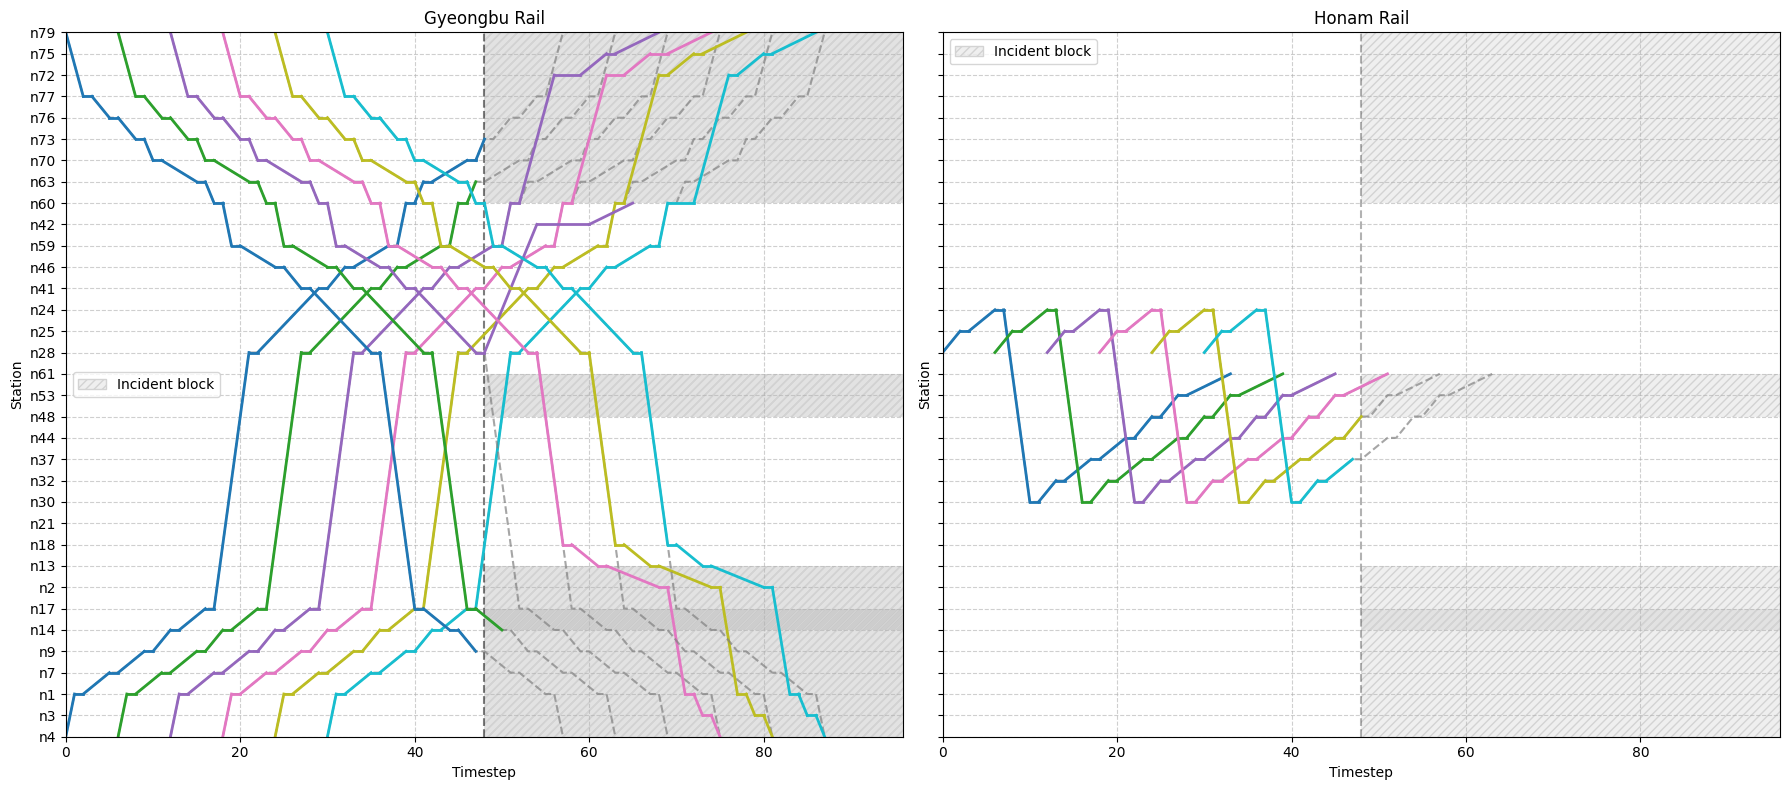

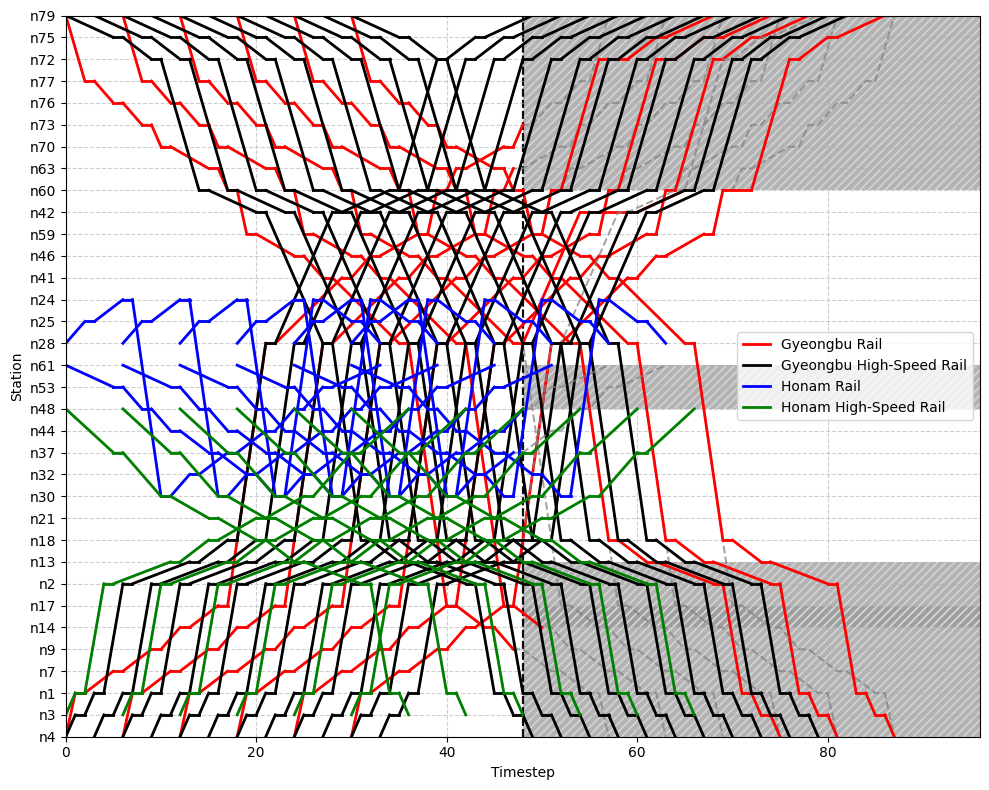

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import Counter

def merge_orders(base_order, new_order):
    res = list(base_order)
    for i, node in enumerate(new_order):
        if node in res:
            continue
        prev_node = new_order[i-1] if i > 0 else None
        next_node = new_order[i+1] if i+1 < len(new_order) else None
        if prev_node in res:
            res.insert(res.index(prev_node) + 1, node)
        elif next_node in res:
            res.insert(res.index(next_node), node)
        else:
            res.append(node)
    return res

def build_canonical_station_order(route_ids, routes_nodes):
    order = []
    for rid in route_ids:
        if rid is None:
            continue
        seq = routes_nodes.get(rid, None)
        if not seq:
            continue
        order = merge_orders(order, seq)
    return order

SINK = "SINK"

def sched_arr(tr, node, default=None):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("arr" in e):
        return e["arr"]
    return default

def sched_dep(tr, node, default=None):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("dep" in e):
        return e["dep"]
    return default

def plot_train_paths(train_list, ax, title, h_get, 
                     routes_nodes, sched, station_map, xmax,
                     color=None, label=None,
                     failed_edges=None, edges=None,
                     incident_x0=None, incident_x1=None,
                     show_incident_line=True, show_incident_legend=True):
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Station")

    order = list(station_map.keys())
    yticks = [station_map[n] for n in order]
    ax.set_yticks(yticks)
    ax.set_yticklabels(order)

    if failed_edges and edges and incident_x0 is not None and incident_x1 is not None:
        drawn_pairs = set()
        for eid in failed_edges:
            if eid not in edges:
                continue
            u, v, _ = edges[eid]
            if (u not in station_map) or (v not in station_map):
                continue
            y0 = station_map[u]; y1 = station_map[v]
            yb, yt = (y0, y1) if y0 <= y1 else (y1, y0)
            key = (min(y0, y1), max(y0, y1))
            if key in drawn_pairs:
                continue
            drawn_pairs.add(key)

            rect = mpatches.Rectangle((incident_x0, yb),   
                                      incident_x1 - incident_x0,  
                                      yt - yb,                  
                                      facecolor=(0.6,0.6,0.6,0.15),  
                                      hatch='////',
                                      edgecolor='lightgray',
                                      linewidth=0,
                                      zorder=0.5)
            ax.add_patch(rect)

        if show_incident_line:
            ax.axvline(incident_x0, color='k', linestyle='--', alpha=0.3, zorder=0.6)

        if show_incident_legend and drawn_pairs:
            patch = mpatches.Patch(facecolor=(0.6,0.6,0.6,0.15), hatch='////',
                                   edgecolor='lightgray', label='Incident block')
            handles, labels = ax.get_legend_handles_labels()
            if 'Incident block' not in labels:
                handles.append(patch)
                labels.append('Incident block')
                ax.legend(handles=handles, labels=labels)

    if color is None:
        cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
        color_iter = (cmap(i % cmap.N) for i in range(len(train_list)))
    else:
        color_iter = (color for _ in range(len(train_list)))

    for tr, tr_color in zip(train_list, color_iter):
        if h_get(tr) < 0.5 and len(sol_legs[tr]) == 0:
            continue

        # planned path (dashed line)
        planned_path = routes_nodes[tr]
        p_nodes = [n for n in planned_path if n in station_map]
        plan_pts = []
        for n in p_nodes:
            t_arr = sched_arr(tr, n, None)
            t_dep = sched_dep(tr, n, None)
            y     = station_map[n]
            if t_arr is not None:
                plan_pts.append((t_arr, y))
            if (t_dep is not None) and (t_arr is not None) and (t_dep < t_arr):
                t_dep = t_arr
            if (t_dep is not None) and (t_dep != t_arr):
                plan_pts.append((t_dep, y))
        plan_pts = sorted(plan_pts, key=lambda xy: xy[0])
        if len(plan_pts) >= 2:
            p_times, p_ys = zip(*plan_pts)
            ax.plot(list(p_times), list(p_ys), linestyle='--', color='gray', alpha=0.7)

        # actual path (solid line)
        actual_legs = sorted(sol_legs[tr], key=lambda x: x[0])
        if not actual_legs:
            continue
        t0, u, v, t1, _ = actual_legs[0]
        if u in station_map and v in station_map:
            ax.plot([t0, t1], [station_map[u], station_map[v]], 
                    color=tr_color, linewidth=2, label=label)
            label = None
        for i in range(1, len(actual_legs)):
            p_t0, p_u, p_v, p_t1, _ = actual_legs[i-1]
            c_t0, c_u, c_v, c_t1, _ = actual_legs[i]
            # 대기(정차) — 열차 색으로 실선 연결
            if c_t0 > p_t1 and p_v == c_u and p_v in station_map:
                ax.plot([p_t1, c_t0], [station_map[p_v], station_map[c_u]],
                        color=tr_color, linewidth=2)  # linestyle 생략 = 실선
            if c_u in station_map and c_v in station_map:
                ax.plot([c_t0, c_t1], [station_map[c_u], station_map[c_v]], 
                        color=tr_color, linewidth=2)

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, xmax)
    ax.set_ylim(1, len(station_map))


gbrt_trains = [tr for tr in trains if str(tr).startswith('경부고속철도1')]
gbs_trains  = [tr for tr in trains if str(tr).startswith('경부선1')]
gbrt2_trains = [tr for tr in trains if str(tr).startswith('경부고속철도2')]
gbs2_trains  = [tr for tr in trains if str(tr).startswith('경부선2')]
gbh_trains  = [tr for tr in trains if str(tr).startswith('호남선1')]
gbh2_trains  = [tr for tr in trains if str(tr).startswith('호남선2')]
gbhrt_trains  = [tr for tr in trains if str(tr).startswith('호남고속철도1')]
gbhrt2_trains  = [tr for tr in trains if str(tr).startswith('호남고속철도2')]

def pick_representative(tr_list):
    return max(tr_list, key=lambda tr: len(routes_nodes[tr])) if tr_list else None

merge_route_ids = []
if '경부고속철도1_1' in routes_nodes:
    merge_route_ids.append('경부고속철도1_1')
elif gbrt_trains:
    merge_route_ids.append(pick_representative(gbrt_trains))

if '경부선1_1' in routes_nodes:
    merge_route_ids.append('경부선1_1')
elif gbs_trains:
    merge_route_ids.append(pick_representative(gbs_trains))

if '경부고속철도2_1' in routes_nodes:
    merge_route_ids.append('경부고속철도2_1')
elif gbrt_trains:
    merge_route_ids.append(pick_representative(gbrt_trains))

if '경부선2_1' in routes_nodes:
    merge_route_ids.append('경부선2_1')
elif gbs_trains:
    merge_route_ids.append(pick_representative(gbs_trains))

if '호남고속철도1_1' in routes_nodes:
    merge_route_ids.append('호남고속철도1_1')
elif gbh_trains:
    merge_route_ids.append(pick_representative(gbh_trains))

if '호남고속철도2_1' in routes_nodes:
    merge_route_ids.append('호남고속철도2_1')
elif gbh_trains:
    merge_route_ids.append(pick_representative(gbh_trains))

if '호남선1_1' in routes_nodes:
    merge_route_ids.append('호남선1_1')
elif gbh_trains:
    merge_route_ids.append(pick_representative(gbh_trains))

if '호남선2_1' in routes_nodes:
    merge_route_ids.append('호남선2_1')
elif gbh_trains:
    merge_route_ids.append(pick_representative(gbh_trains))


if not merge_route_ids:
    merge_route_ids = [pick_representative(trains)]

canonical_order = build_canonical_station_order(merge_route_ids, routes_nodes)
if not canonical_order:
    from collections import Counter
    cnt = Counter(n for seq in routes_nodes.values() for n in seq if n != SINK)
    canonical_order = [n for n, _ in cnt.most_common()]
station_map = {name: i+1 for i, name in enumerate(canonical_order)}

def h_get(tr):
    return float(h_final.get(tr, 1.0))

# --- fig.1 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# High-Speed subplot
#plot_train_paths(
#    gbrt_trains, ax1, "Gyeongbu High-Speed Rail",
#    h_get, routes_nodes, sched, station_map, xmax=96,
#    failed_edges=failed_edges, edges=edges,
#    incident_x0=FAIL_T, incident_x1=T_clear
#)
#plot_train_paths(
#    gbrt2_trains, ax1, None,   # 제목은 한 번만
#    h_get, routes_nodes, sched, station_map, xmax=96,
#    failed_edges=failed_edges, edges=edges,
#    incident_x0=FAIL_T, incident_x1=T_clear
#)

# Conventional subplot
plot_train_paths(
    gbs_trains, ax1, "Gyeongbu Rail",
    h_get, routes_nodes, sched, station_map, xmax=96,
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)
plot_train_paths(
    gbs2_trains, ax1, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)

plot_train_paths(
    gbh_trains, ax2, "Honam Rail",
    h_get, routes_nodes, sched, station_map, xmax=96,
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)

#plot_train_paths(
#    gbh2_trains, ax2, None,
#    h_get, routes_nodes, sched, station_map, xmax=96,
#    failed_edges=failed_edges, edges=edges,
#    incident_x0=FAIL_T, incident_x1=T_clear
#)

fig.tight_layout()

# --- fig.2 (합쳐 그리기) ---
fig2, ax = plt.subplots(figsize=(10, 8))

# High-Speed (검정) — 라벨은 한 번만
plot_train_paths(
    gbs_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="red", label="Gyeongbu Rail",
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)
plot_train_paths(
    gbs2_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="red", label=None,
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)

# Conventional (빨강) — 라벨은 한 번만
plot_train_paths(
    gbrt_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="black", label="Gyeongbu High-Speed Rail",
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)
plot_train_paths(
    gbrt2_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="black", label=None,
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)

# Conventional (파랑) — 라벨은 한 번만
plot_train_paths(
    gbh_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="blue", label="Honam Rail",
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)
plot_train_paths(
    gbh2_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="blue", label=None,
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)

# Conventional (파랑) — 라벨은 한 번만
plot_train_paths(
    gbhrt_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="green", label="Honam High-Speed Rail",
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)
plot_train_paths(
    gbhrt2_trains, ax, None,
    h_get, routes_nodes, sched, station_map, xmax=96,
    color="green", label=None,
    failed_edges=failed_edges, edges=edges,
    incident_x0=FAIL_T, incident_x1=T_clear
)


ax.legend()
fig2.tight_layout()
plt.show()


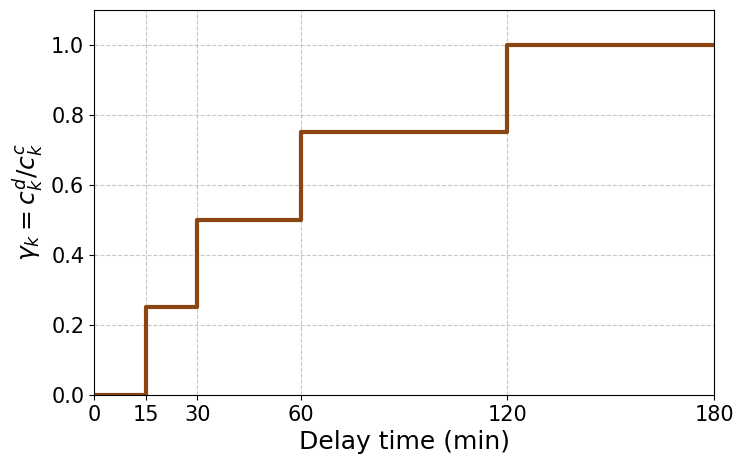

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Delay 구간 경계 (분)
delay_bins = [0, 15, 30, 60, 120, 180]  # 180분까지 표시
# 환불 비율 (r 값)
refund_ratio = [0, 0.25, 0.5, 0.75, 1.0, 1.0]

# 그래프 그리기 (계단 함수)
plt.figure(figsize=(8,5))
plt.step(delay_bins, refund_ratio, where="post", 
         label="Refund ratio r", 
         linewidth=3,        # 선 두께
         color="saddlebrown" # 갈색
        )

# 축 레이블 & 제목 (폰트 크기 조정)
plt.xlabel("Delay time (min)", fontsize=18)
plt.ylabel(r"$\gamma_k=c_k^d / c_k^c$", fontsize=18)

# y축 0~1.1
plt.ylim(0, 1.1)
plt.xlim(0, 180)

# 눈금 & 격자 (눈금 폰트 크기 키우기)
plt.xticks([0,15,30,60,120,180], fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()
